In [1]:
import os
import json
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting, DiscreteAllocation, objective_functions

In [2]:
# -------------------------------
# Config
# -------------------------------
MODELS_DIR = os.path.join("..", "models")         # same location you used before
FORECAST_CSV = os.path.join(MODELS_DIR, "tsla_lstm_forecast_mc_dropout.csv")
METADATA_FILE = os.path.join(MODELS_DIR, "tsla_lstm_metadata.json")

TICKER_TSLA = "TSLA"
TICKERS_OTHER = ["BND", "SPY"]
ALL_TICKERS = [TICKER_TSLA] + TICKERS_OTHER

TRADING_DAYS = 252    # used for annualization

In [6]:
# -------------------------------
# Load metadata & forecast
# -------------------------------
if not os.path.exists(FORECAST_CSV):
    raise FileNotFoundError(f"Forecast CSV not found at {FORECAST_CSV}. Run Task 3 first.")

with open(METADATA_FILE, "r") as f:
    metadata = json.load(f)

# Historical data range used for training (metadata)
hist_start = metadata.get("start_date", "2015-07-01")
hist_end = metadata.get("end_date", "2025-07-31")

# Forecasted TSLA mean series
forecast_df = pd.read_csv(FORECAST_CSV, parse_dates=["date"], index_col="date")
if "forecast_mean" not in forecast_df.columns:
    raise KeyError("forecast_mean column not found in forecast CSV.")

forecast_prices = forecast_df["forecast_mean"].to_numpy().astype(float).ravel()

hist_full = yf.download(TICKER_TSLA, start=hist_start, end=hist_end, progress=False)
last_hist_price = float(hist_full["Close"].dropna().iloc[-1])

# Concatenate as 1-D
aug_prices = np.concatenate(([last_hist_price], forecast_prices))  # length = forecast_days + 1
forecast_daily_returns = (aug_prices[1:] / aug_prices[:-1]) - 1.0

tsla_exp_daily = np.nanmean(forecast_daily_returns)
tsla_exp_annual = (1 + tsla_exp_daily) ** TRADING_DAYS - 1

print(f"TSLA expected daily return (from forecast): {tsla_exp_daily:.6f}")
print(f"TSLA expected annualized return (from forecast): {tsla_exp_annual:.4%}")

TSLA expected daily return (from forecast): -0.000252
TSLA expected annualized return (from forecast): -6.1590%


C:\Users\hp\AppData\Local\Temp\ipykernel_14680\1871343030.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  hist_full = yf.download(TICKER_TSLA, start=hist_start, end=hist_end, progress=False)
C:\Users\hp\AppData\Local\Temp\ipykernel_14680\1871343030.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_hist_price = float(hist_full["Close"].dropna().iloc[-1])


In [7]:
# -------------------------------
# Load historical price data for BND and SPY (use same historical window)
# -------------------------------
print(f"Fetching historical data for {', '.join(TICKERS_OTHER)} from {hist_start} to {hist_end} ...")
df_other = yf.download(TICKERS_OTHER, start=hist_start, end=hist_end)["Close"].dropna()
# compute daily returns
returns_other = df_other.pct_change().dropna()
# historical expected returns (annualized mean of daily returns)
exp_returns_other_annual = (1 + returns_other.mean()) ** TRADING_DAYS - 1
# convert to dict-like
exp_returns_other_annual = exp_returns_other_annual.to_dict()

C:\Users\hp\AppData\Local\Temp\ipykernel_14680\3211905243.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_other = yf.download(TICKERS_OTHER, start=hist_start, end=hist_end)["Close"].dropna()
[*********************100%***********************]  2 of 2 completed

Fetching historical data for BND, SPY from 2015-07-01 to 2025-07-31 ...


In [9]:
# -------------------------------
# Build expected returns vector (annual)
# -------------------------------
# TSLA from forecast, BND & SPY from historical mean
mu_annual = pd.Series({
    TICKER_TSLA: tsla_exp_annual,
    "BND": exp_returns_other_annual.get("BND", 0.0),
    "SPY": exp_returns_other_annual.get("SPY", 0.0)
})

print("\nExpected annual returns (used in optimization):")
print(mu_annual.round(6))


Expected annual returns (used in optimization):
TSLA   -0.061590
BND     0.019792
SPY     0.155812
dtype: float64


In [12]:
# -------------------------------
# Build covariance matrix (annualized)
# -------------------------------
# Use historical daily returns of TSLA,BND,SPY for covariance calculation
df_tsla_hist = hist_full["Close"].dropna()
returns_tsla_hist = df_tsla_hist.pct_change().dropna()
# Set the series name explicitly (avoids rename TypeError)
returns_tsla_hist.name = TICKER_TSLA

# Ensure other returns columns are plain (yfinance may give MultiIndex)
if isinstance(returns_other.columns, pd.MultiIndex):
    returns_other.columns = returns_other.columns.get_level_values(-1)

# Align returns DataFrame: TSLA, BND, SPY
returns_df = pd.concat([returns_tsla_hist, returns_other], axis=1).dropna()

# Optional sanity checks
# print("Returns_df columns:", returns_df.columns.tolist())
# print("Any NaNs?", returns_df.isna().sum().to_dict())

# Sample covariance of daily returns, then annualize
cov_annual = returns_df.cov() * TRADING_DAYS

print("\nAnnualized covariance matrix:")
print(cov_annual.round(6))


Annualized covariance matrix:
Ticker      TSLA       BND       SPY
Ticker                              
TSLA    0.350331  0.001861  0.052950
BND     0.001861  0.003016  0.001150
SPY     0.052950  0.001150  0.033272


In [14]:
# -------------------------------
# Run portfolio optimization (PyPortfolioOpt)
# -------------------------------
# Note: PyPortfolioOpt expects expected_returns as a pd.Series and cov matrix as pd.DataFrame with same indices
# Ensure cov_annual and mu_annual indices align and are in same order
cov_annual = cov_annual.reindex(index=mu_annual.index, columns=mu_annual.index).fillna(0)

# Create EfficientFrontier object
ef = EfficientFrontier(mu_annual, cov_annual, weight_bounds=(0,1))  # no shorting

# Max Sharpe (tangency portfolio)
raw_weights_sharpe = ef.max_sharpe()
weights_sharpe = ef.clean_weights()
perf_sharpe = ef.portfolio_performance(verbose=False)  # (expected_return, volatility, sharpe)

# Recreate for min vol since ef mutates internal state
ef_minvol = EfficientFrontier(mu_annual, cov_annual, weight_bounds=(0,1))
raw_weights_minvol = ef_minvol.min_volatility()
weights_minvol = ef_minvol.clean_weights()
perf_minvol = ef_minvol.portfolio_performance(verbose=False)

In [15]:
# Results & reporting
# -------------------------------
def pretty_weights(w):
    return {k: round(v, 4) for k, v in w.items() if v > 1e-6}

print("\nMaximum Sharpe Ratio Portfolio (weights):")
print(pretty_weights(weights_sharpe))
print("Performance (annualized):")
print(f"  Expected return: {perf_sharpe[0]:.2%}")
print(f"  Volatility (std): {perf_sharpe[1]:.2%}")
print(f"  Sharpe Ratio: {perf_sharpe[2]:.4f}")

print("\nMinimum Volatility Portfolio (weights):")
print(pretty_weights(weights_minvol))
print("Performance (annualized):")
print(f"  Expected return: {perf_minvol[0]:.2%}")
print(f"  Volatility (std): {perf_minvol[1]:.2%}")
print(f"  Sharpe Ratio: {perf_minvol[2]:.4f}")


Maximum Sharpe Ratio Portfolio (weights):
{'BND': 0.5173, 'SPY': 0.4827}
Performance (annualized):
  Expected return: 8.54%
  Volatility (std): 9.56%
  Sharpe Ratio: 0.8941

Minimum Volatility Portfolio (weights):
{'BND': 0.9451, 'SPY': 0.0549}
Performance (annualized):
  Expected return: 2.73%
  Volatility (std): 5.40%
  Sharpe Ratio: 0.5050


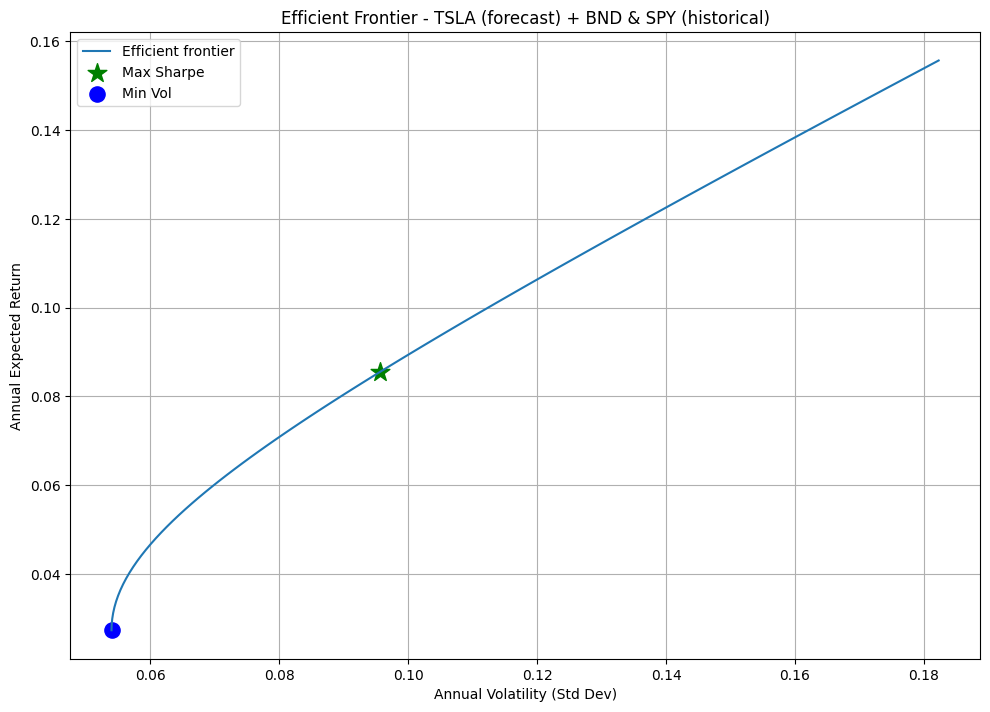

In [17]:
# -------------------------------
# Plot Efficient Frontier
# -------------------------------
plt.figure(figsize=(10, 7))
ax = plt.gca()

# Fresh (unsolved) instance for frontier plotting
ef_frontier = EfficientFrontier(mu_annual, cov_annual, weight_bounds=(0,1))
plotting.plot_efficient_frontier(ef_frontier, show_assets=False, ax=ax)

def port_coords(mu, cov, weights):
    w = np.array([weights[t] for t in mu.index])
    port_ret = float(np.dot(w, mu.values))
    port_vol = float(np.sqrt(np.dot(w.T, np.dot(cov.values, w))))
    return port_ret, port_vol

sharpe_ret, sharpe_vol = port_coords(mu_annual, cov_annual, weights_sharpe)
minvol_ret, minvol_vol = port_coords(mu_annual, cov_annual, weights_minvol)

ax.scatter(sharpe_vol, sharpe_ret, marker="*", s=200, c="green", label="Max Sharpe")
ax.scatter(minvol_vol, minvol_ret, marker="o", s=120, c="blue", label="Min Vol")

ax.set_xlabel("Annual Volatility (Std Dev)")
ax.set_ylabel("Annual Expected Return")
ax.set_title("Efficient Frontier - TSLA (forecast) + BND & SPY (historical)")
ax.legend()
ax.grid(True)
plt.show()

In [18]:
# -------------------------------
# Save outputs
# -------------------------------
out_dir = os.path.join(MODELS_DIR, "task4_outputs")
os.makedirs(out_dir, exist_ok=True)

results = {
    "expected_returns_annual": mu_annual.round(6).to_dict(),
    "covariance_annual": cov_annual.round(6).to_dict(),
    "max_sharpe": {
        "weights": pretty_weights(weights_sharpe),
        "performance": {
            "expected_return": perf_sharpe[0],
            "volatility": perf_sharpe[1],
            "sharpe": perf_sharpe[2]
        }
    },
    "min_volatility": {
        "weights": pretty_weights(weights_minvol),
        "performance": {
            "expected_return": perf_minvol[0],
            "volatility": perf_minvol[1],
            "sharpe": perf_minvol[2]
        }
    },
    "metadata_used": {
        "hist_start": hist_start,
        "hist_end": hist_end,
        "forecast_horizon_days": int(len(forecast_df))
    }
}

results_file = os.path.join(out_dir, "task4_results.json")
with open(results_file, "w") as f:
    json.dump(results, f, indent=2)
print(f"\nSaved Task 4 results to: {results_file}")


Saved Task 4 results to: ..\models\task4_outputs\task4_results.json
